In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from google.colab import drive
drive.mount('/content/drive')

# Assuming vehicles.csv is in the same directory as your Colab notebook
# in your Google Drive. Adjust the path if necessary
file_path = "/content/drive/MyDrive/group_project_data_mining/vehicles.csv"

try:
  df_vehicles = pd.read_csv(file_path)
  print("File loaded successfully.")
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
except pd.errors.ParserError:
    print(f"Error: Could not parse the file at {file_path}. Check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully.


In [ ]:
# Dataset Import
file_path = "vehicles.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "austinreese/craigslist-carstrucks-data",
  file_path
)

print("First 5 records:", df.head())

<ipython-input-3-1fe2a086dbb5>:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:            id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN   
2            florida keys        https://keys.craigslist.org  21000   NaN   
3  worcester / central MA   https://worcester.craigslist.org   1500   NaN   
4              greensboro  https://greensboro.craigslist.org   4900   NaN   

  manufacturer model condition cylinders  ... size  type paint_color  \
0          NaN   NaN       NaN       Na

In [ ]:
# Data Preprocessing
df = df.dropna(subset=['price', 'cylinders', 'year', 'odometer']) # Remove all rows with null values in any of the four categories

df = df[df['cylinders'] != "other"] # for some reason, some rows have a 'other' value for cylinders, so we shall remove these rows

df['cylinders'] = df['cylinders'].str[0].astype(int) # convert "8 cylinders" to the value 8, and so on for every num of cylinders

Matthew's Linear Regression

In [ ]:
# 1) Keep only the three columns we care about
data = df[['price', 'year', 'odometer', 'cylinders']].copy()

# 3) Define X and y
X = data[['year', 'odometer', 'cylinders']]
y = data['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Fit a simple linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# 6) Evaluate on the test set
y_pred = model.predict(X_test)
print(f"R² score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE:       {mean_squared_error(y_test, y_pred):.2f}\n")

# 7) Show learned parameters
print(f"Intercept: {model.intercept_:.2f}")
coef_df = pd.Series(model.coef_, index=X.columns)
print("Coefficients:")
print(coef_df)

R² score: -0.0000
MSE:       594477277376181.75

Intercept: -4938384.90
Coefficients:
year          2417.462725
odometer        -0.017140
cylinders    19610.846592
dtype: float64


Logan's Polynomial Regression


Polynomial feature names:
['year' 'cylinders' 'odometer' 'year^2' 'year cylinders' 'year odometer'
 'cylinders^2' 'cylinders odometer' 'odometer^2']

Model coefficients:
year: 0.0000
cylinders: 0.0051
odometer: 3.6315
year^2: 0.1479
year cylinders: 10.3488
year odometer: -0.0017
cylinders^2: 0.0598
cylinders odometer: -0.0239
odometer^2: -0.0000
Intercept: -680973.8070

Model Evaluation:
Mean Squared Error (MSE): 309820494941462.31
Root Mean Squared Error (RMSE): 17601718.52
R-squared (R²): 0.0000

Predicted price for a car with 85000 miles, 6 cylinders, from year 2018: $57885.61


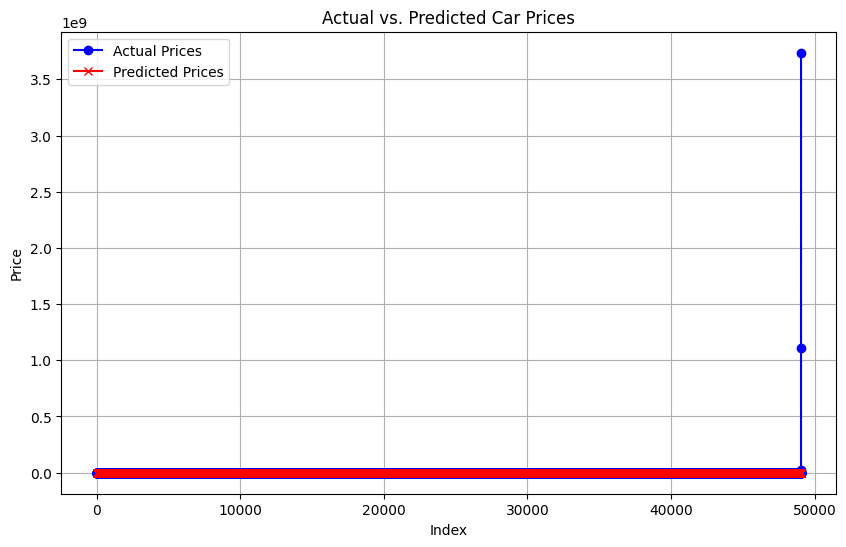

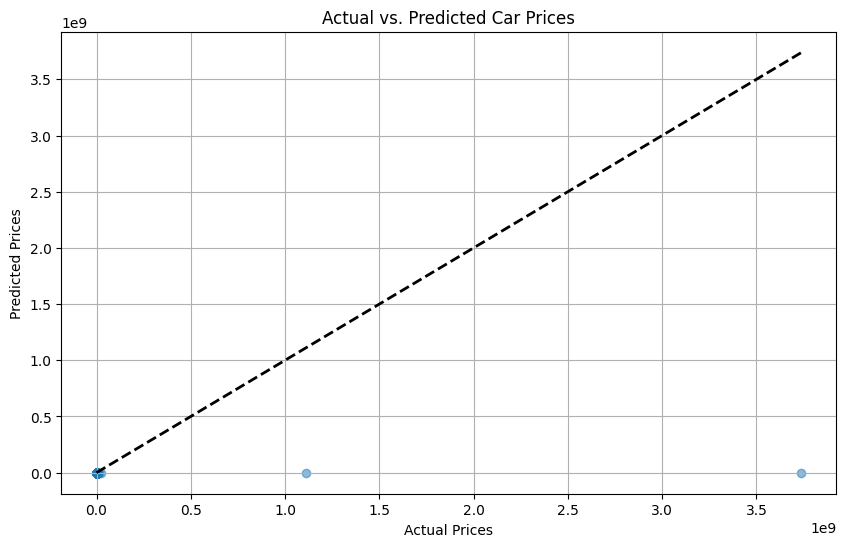

In [ ]:
# valuable LABELS: price, year, manufacturer, model, condition, cylinders, fuel, odometer,
#                  title_status, transmission, drive, size, type, paint_color, posting_date

# for now, use only the numerical ones:
#     price, year, cylinders, odometer

X = df[['year', 'cylinders', 'odometer']]  # Input features
y = df['price']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform the features
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Display the new feature names
feature_names = poly.get_feature_names_out(X.columns)
print("\nPolynomial feature names:")
print(feature_names)

# Create and train the polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Display the coefficients
print("\nModel coefficients:")
for i, coef in enumerate(poly_reg.coef_):
    print(f"{feature_names[i]}: {coef:.4f}")
print(f"Intercept: {poly_reg.intercept_:.4f}")

# Make predictions on the test set
y_pred = poly_reg.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

# Create a DataFrame with actual and predicted prices
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort by actual price for better visualization
results = results.sort_values(by='Actual')

# Reset index
results = results.reset_index(drop=True)

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Actual'], label='Actual Prices', color='blue', marker='o')
plt.plot(results.index, results['Predicted'], label='Predicted Prices', color='red', marker='x')
plt.title('Actual vs. Predicted Car Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')

# Plot a scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(results['Actual'], results['Predicted'], alpha=0.5)
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()],
         'k--', lw=2)
plt.title('Actual vs. Predicted Car Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.savefig('scatter_plot.png')




def predict_car_price(year, cylinders, mileage):
    # Create a DataFrame with the new car's features
    new_car = pd.DataFrame({
        'year': [year],
        'cylinders': [cylinders],
        'odometer': [mileage]
    })

    # Transform the features to polynomial features
    new_car_poly = poly.transform(new_car)

    # Predict the price
    predicted_price = poly_reg.predict(new_car_poly)[0]

    return predicted_price

# Example usage
year = 2018
cylinders = 6
mileage = 85000
predicted_price = predict_car_price(year, cylinders, mileage)
print(f"\nPredicted price for a car with {mileage} miles, {cylinders} cylinders, from year {year}: ${predicted_price:.2f}")


Dheeraj's Decision tree model:


everett's neural network